# Example notebook: Quantum Models

In this notebook we demonstrate how train the variational classifier using one of the following post processing models:

- Expected values model
- Modulo model
- Parity model


We compute the accuracy versus training iterations on the Wine dataset using 8 features and 3 classes.


In [1]:
import warnings
from typing import Any, List, Optional

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from sklearn.preprocessing import StandardScaler

from tno.quantum.ml.classifiers.vc import VariationalClassifier
from tno.quantum.ml.datasets import get_wine_dataset

warnings.filterwarnings("ignore")

import imageio
import pandas as pd
import seaborn as sns
from IPython.display import Image

sns.set_theme()

In [2]:
# Load Wine dataset:
X_training, y_training, X_validation, y_validation = get_wine_dataset(
    n_features=8, n_classes=3, random_seed=0
)


def _std_scale(X_training: NDArray[np.float_], X_validation: NDArray[np.float_]):
    std_scale = StandardScaler().fit(X_training)
    return std_scale.transform(X_training), std_scale.transform(X_validation)


# Preprocess data
X_training, X_validation = _std_scale(X_training, X_validation)
X_training = X_training / np.linalg.norm(X_training, ord=2, axis=-1)[:, None]
X_validation = X_validation / np.linalg.norm(X_validation, ord=2, axis=-1)[:, None]

In [3]:
def get_models(random_state: Optional[int] = None) -> dict[str, VariationalClassifier]:
    """
    Get different VC models with the same random_state.

    Args:
        random_state: random seed for repeatability.

    Returns:
        Dict containing VariationalClassifier instances with different post processing
        models: expected values model, modulo model and parity model.
    """
    models = {
        "Expected Values Model": VariationalClassifier(
            batch_size=10,
            backend={"name": "default.qubit", "options": {}},
            model={
                "name": "expected_values_model",
                "options": {"n_layers": 2, "n_trainable_sublayers": 2, "scaling": 0.3},
            },
            optimizer={"name": "adam", "options": {}},
            use_bias=False,
            random_init=True,
            warm_init=True,
            random_state=random_state,
        ),
        "Modulo Model": VariationalClassifier(
            batch_size=10,
            backend={"name": "default.qubit", "options": {}},
            model={
                "name": "modulo_model",
                "options": {"n_layers": 2, "n_trainable_sublayers": 2, "scaling": 0.3},
            },
            optimizer={"name": "adam", "options": {}},
            use_bias=False,
            random_init=True,
            warm_init=True,
            random_state=random_state,
        ),
        "Parity Model": VariationalClassifier(
            batch_size=10,
            backend={"name": "default.qubit", "options": {}},
            model={
                "name": "parity_model",
                "options": {"n_layers": 2, "n_trainable_sublayers": 2, "scaling": 0.3},
            },
            optimizer={"name": "adam", "options": {}},
            use_bias=False,
            random_init=True,
            warm_init=True,
            random_state=random_state,
        ),
    }
    return models

In [4]:
def get_dataframe(max_iterations: int = 150, number_of_instances: int = 1) -> pd.DataFrame:
    """
    Get DataFrame that can be used to generate accuracy and violin plots.

    For each of the three model types, for every 10 iterations up till max_iterations,
    predictions are computed on validation and training data. Computation is repeated
    number_of_instances times.

    Args:
        max_iterations: number of iterations the models need to be trained.
        number_of_instances: number of times computation is repeated

    Returns:
        DataFrame containing predictions and accuracy.
    """

    def _accuracy(labels: NDArray[Any], predictions: NDArray[Any]) -> np.float_:
        return np.sum(np.isclose(labels, predictions)) / labels.size

    columns = [
        "Model",
        "Iteration",
        "Accuracy",
        "Dataset",
        "Predictions",
        "Random state"
    ]
    df = pd.DataFrame(columns=columns)
    for i in range(number_of_instances):
        models = get_models(random_state=42 + i)
        for model_name, vc in models.items():
            for iteration in range(10, max_iterations + 1, 10):
                vc.fit(X_training, y_training, n_iter=10)

                predictions_validation = vc.predict(X_validation)
                df = df.append(
                    {
                        "Model": model_name,
                        "Iteration": iteration,
                        "Accuracy": _accuracy(y_validation, predictions_validation),
                        "Dataset": "Validation",
                        "Predictions": predictions_validation,
                        "Random state": 42 + i,
                    },
                    ignore_index=True,
                )
                predictions_training = vc.predict(X_training)
                df = df.append(
                    {
                        "Model": model_name,
                        "Iteration": iteration,
                        "Accuracy": _accuracy(y_training, predictions_training),
                        "Dataset": "Training",
                        "Predictions": predictions_training,
                        "Random state": 42 + i,
                    },
                    ignore_index=True,
                )
    return df

In [5]:
df = get_dataframe(100, number_of_instances=1)

Training iteration: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it]


In [6]:
def plot_accuracy(df: pd.DataFrame):
    """Plot accuracy score for training and validation data for different models"""
    sns.relplot(
        data=df,
        x="Iteration",
        y="Accuracy",
        col="Dataset",
        kind="line",
        hue="Model",
        style="Model",
    )
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()


def plot_violin(
    df: pd.DataFrame,
    model: str = "Expected Values Model",
    iteration: int = 5,
    random_state: int = 42,
    dataset: str = "Validation",
    show: bool = True,
):
    """Plot violin plot for validation data for specific iteration and model"""
    fig, ax = plt.subplots()
    filtered_df = df.loc[
        (df["Random state"] == random_state)
        & (df["Dataset"] == dataset)
        & (df["Iteration"] == iteration)
        & (df["Model"] == model)
    ]
    predictions = filtered_df.iloc[0]["Predictions"]
    true_label = y_validation if dataset == "Validation" else y_training
    df = pd.DataFrame(
        {
            "True label": true_label.astype(int),
            "Predicted label": predictions.astype(int),
        }
    )
    sns.violinplot(data=df, x="True label", y="Predicted label", linewidth=0.5)
    ax = plt.gca()
    ax.set_yticks([0, 1, 2])

    ax.set_title(f"{model}")
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.text(xlim[0], ylim[1] - 0.2, f"Iteration: {iteration}", fontsize=15)

    # Save image so an GIF-image can be created
    plt.savefig(f"images/image-violin-{iteration}.png")
    if show == True:
        plt.show()
    else:
        plt.close()

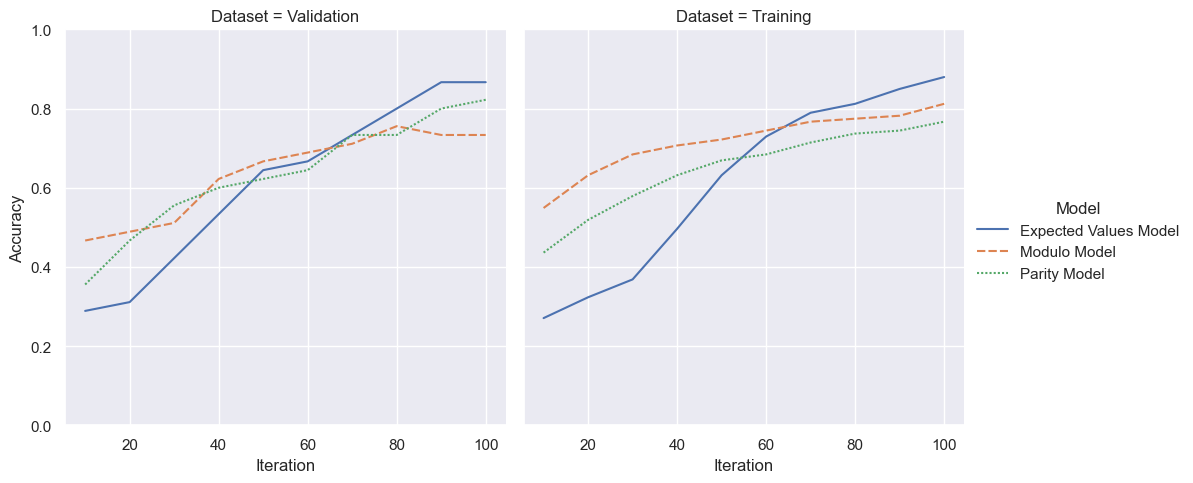

In [7]:
plot_accuracy(df)

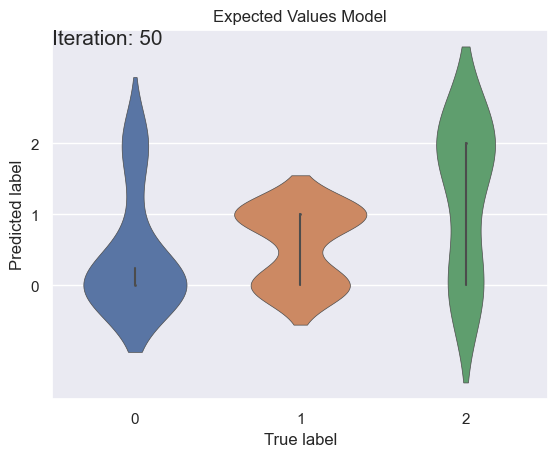

In [8]:
plot_violin(df, model ="Expected Values Model", iteration=50, random_state = 42, dataset="Validation")

In [11]:
def create_violin_gif(
    df: pd.DataFrame,
    iterations: List[int],
    model: str = "Expected Values Model",
    random_state: int = 42,
    dataset: str = "Validation",
):
    """Create violin gif"""
    images = []
    for iteration in iterations:
        plot_violin(df, model, iteration, random_state, dataset, show=False)
        images.append(imageio.imread(f"images/image-violin-{iteration}.png"))
    for _ in range(5):
        images.append(images[-1])
    imageio.mimsave("images/violin.gif", images, duration=0.5)


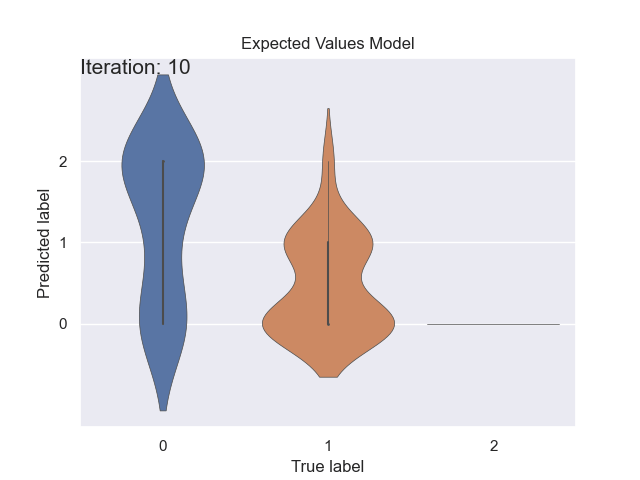

In [12]:
create_violin_gif(df, iterations = [10, 20, 30, 40, 50, 60, 70, 80, 90])
Image(filename='images/violin.gif')